# Perform a simple deconvolution using Richardson-Lucy

## Load data and prepare operators

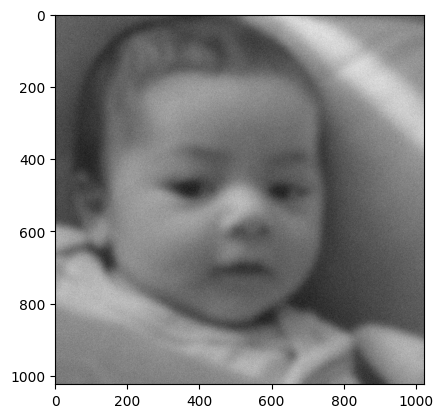

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import richardon_lucy as rl
import noise
import blur
from PIL import Image

device = "cuda"

k_size = 61
k_std = 10.0
n_std = 0.05

# Load the data
y = Image.open('img/00000.png').convert('L')
y = torch.from_numpy(np.array(y)).unsqueeze(0).unsqueeze(0).to(device).float() / 255.0
gaussianblur = blur.GaussianBlur(k_size, k_std).to(device)
k = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)

noiser = noise.GaussianNoise(n_std)

# Blur the image
y = gaussianblur(y)

# Add noise
y = noiser(y)

plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')

## Perform the non-blind deconvolution

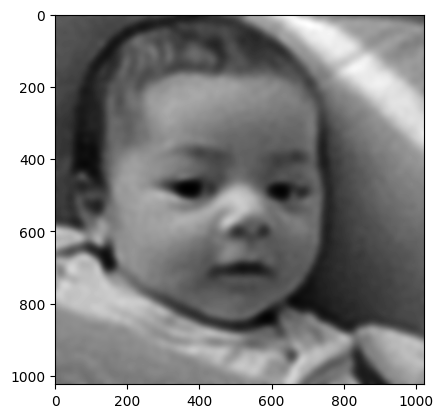

In [13]:
x_0 = torch.ones_like(y) 

res = rl.richardson_lucy(y, x_0, k, steps= 10, clip=True, filter_epsilon=1e-6)
plt.imshow(res[0, 0].detach().cpu().numpy(), cmap='gray')
